In [1]:
from datasets import load_dataset
dataset = load_dataset("rfcx/frugalai", streaming = True)

In [2]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import json

SAMPLE_RATE = 12000
N_MELS = 64  # Number of Mel bands
N_FFT = 1024  # FFT window size
HOP_LENGTH = 512  # Hop length for STFT

## extracting mel spectogram

In [3]:
def extract_mel_spectrogram(audio_array, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
    # Compute the Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio_array, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    
    # Convert to decibels (log scaling for better representation)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    return mel_spec_db

def plot_mel_spectrogram(mel_spec, sr=SAMPLE_RATE, hop_length=HOP_LENGTH):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()

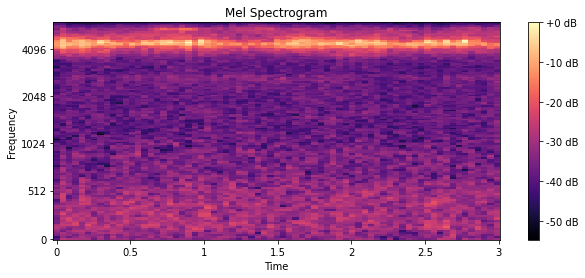

In [4]:
sample_instance = next(iter(dataset['train']))
    
mel_spectrogram = extract_mel_spectrogram(sample_instance['audio']['array'])
plot_mel_spectrogram(mel_spectrogram)

## preprocessing

In [5]:
def extract_features(audio, sr=SAMPLE_RATE, n_mfcc=13, n_mels= N_MELS, hop_length= HOP_LENGTH):
    """
    Extracts Mel Spectrogram and MFCC features from an audio waveform.
    
    Parameters:
        audio (numpy array): The raw audio waveform.
        sr (int): Sampling rate (default: 12000).
        n_mfcc (int): Number of MFCCs to extract (default: 13).
        n_mels (int): Number of mel bands (default: 128).
        hop_length (int): Hop length for STFT (default: 512).
    
    Returns:
        numpy array: Concatenated feature vector.
    """

    # Compute Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, 
                                              sr=sr, 
                                              n_mels=n_mels, 
                                              n_fft = 2048, 
                                              window = 'hann', 
                                              hop_length=hop_length)
    
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB scale

    # Compute MFCCs
    mfccs = librosa.feature.mfcc(
        S=librosa.power_to_db(mel_spec),
        n_mfcc=n_mfcc,
        sr=sr)
    
    # Flatten and concatenate features
    features = np.hstack((
        np.mean(mel_spec_db, axis=1),
        np.mean(mfccs, axis=1),
        np.std(mel_spec_db, axis=1),
        np.std(mfccs, axis=1)))

    return features

In [6]:
def prepare_dataset(dataset, split="train"):
    """
    Prepares dataset by extracting features from all audio samples.

    Parameters:
        dataset: The dataset dictionary loaded from Hugging Face `datasets`
        split (str): The dataset split ("train", "test", etc.)

    Returns:
        Tuple (X, y): Feature matrix and labels
    """
    X, y = [], []

    for sample in dataset[split]:
        audio_data = sample['audio']['array']
        label = sample['label']  

        features = extract_features(audio_data)
        X.append(features)
        y.append(label)

    return np.array(X), np.array(y)

In [7]:
X_train, y_train = prepare_dataset(dataset, split="train")
X_test, y_test = prepare_dataset(dataset, split="test")

print(f"Dataset processed: X_train {X_train.shape}, y_train {y_train.shape}")

/Users/rudyferreira/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


Dataset processed: X_train (35277, 141), y_train (35277,)


## model training (CNN)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
print(np.__version__)

1.24.3


In [1]:
# Normalize
X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
X_test = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))

# Reshape for CNN input
X_train = X_train[..., np.newaxis] 
X_test = X_test[..., np.newaxis]

# Convert labels for binary classification
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

NameError: name 'X_train' is not defined

In [2]:
def create_cnn(input_shape):
    model = keras.Sequential([
        layers.Conv1D(64, kernel_size=3, activation="relu", input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(128, kernel_size=3, activation="relu"),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(256, kernel_size=3, activation="relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid") 
    ])

    model.compile(optimizer="adam", loss="binary_crossnetropy", metrics=["accuracy"])
    return model

num_classes = len(np.unique(y_train)) 
model = create_cnn(input_shape=(X_train.shape[1], 1))

model.summary()

NameError: name 'np' is not defined

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Save the trained model
model.save("cnn_chainsaw_detector.h5")

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")